In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.rcParams['font.sans-serif'] = "Latin Modern Roman"
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['mathtext.fontset'] = "cm"
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean

In [2]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

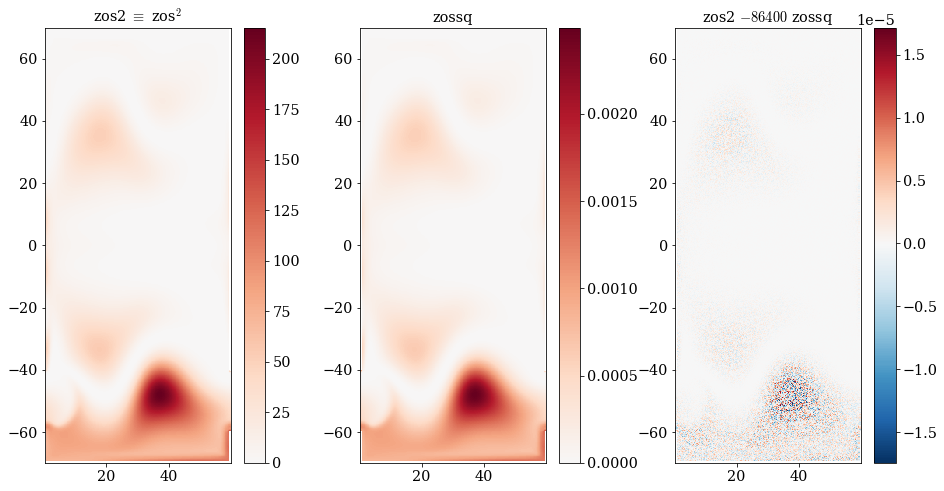

In [3]:
av = xr.open_dataset('run15/averages_00000000.nc', decode_times=False)

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.pcolormesh(av.xh,av.yh,av.zos2.values[1],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'zos2 $\equiv$ zos$^2$')
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(av.xh,av.yh,av.zossq.values[1],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'zossq')
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(av.xh,av.yh,av.zos2.values[1]-av.zossq.values[1]*86400,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'zos2 $- 86400$ zossq')
plt.colorbar()
plt.savefig('Sea surface height.png', dpi=200,bbox_inches='tight',pad_inches=0)

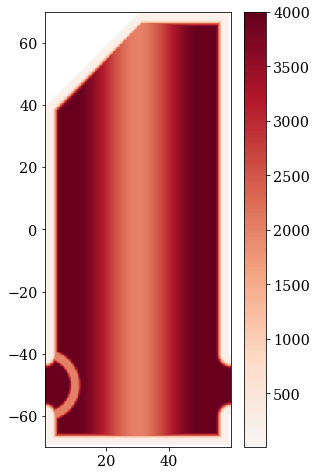

In [4]:
st = xr.open_dataset('run14/static.nc', decode_times=False)
st


plt.figure(figsize=(5,8))
plt.pcolormesh(st.xh,st.yh,st.depth_ocean,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()

## Comparison of effective velocities estimated using 1-day and 5-day averaging

In [5]:
layer_no = 0
end_time = 28500
start_time = end_time - 500

In [6]:
av1 = xr.open_dataset('run9/averages_000%i.nc' % (end_time-500), decode_times=False)
av5 = xr.open_dataset('run9/averages_000%i.nc' % (end_time-500+2), decode_times=False)
st = xr.open_dataset('run9/static.nc', decode_times=False)
lm = xr.open_dataset('run9/longmean_00028250.nc', decode_times=False)

In [7]:
grid = Grid(av1, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} }, periodic=['X'])

def interp_h_to_u(h):
    """Interpolate h to the grid points where u is defined"""
    n,layers,ly,lx = h.shape
    h_at_u = np.zeros((n,layers,ly,lx+1))
    h_at_u[:,:,:,1:-1] = (h[:,:,:,:-1] + h[:,:,:,1:])/2
    h_at_u[:,:,:,0] = (h[:,:,:,0] + h[:,:,:,-1])/2 # periodic
    h_at_u[:,:,:,-1] = (h[:,:,:,0] + h[:,:,:,-1])/2 # periodic
    
    return h_at_u
    
def interp_h_to_v(h):
    """Interpolate h to the grid points where v is defined"""
    n,layers,ly,lx = h.shape
    h_at_v = np.zeros((n,layers,ly+1,lx))
    h_at_v[:,:,1:-1,:] = (h[:,:,:-1,:] + h[:,:,1:,:])/2
    h_at_v[:,:,0,:] = h[:,:,0,:] # non-periodic
    h_at_v[:,:,-1,:] = h[:,:,-1,:] # non-periodic
    
    return h_at_v

In [8]:
# 1-day averaged effective zonal velocity
h_at_u = interp_h_to_u(av1.h.astype(float).values) # m
u_eff1 = (av1.uh.astype(float))/(h_at_u + 1e-20) # m^2/s (divide by st.dyCu to get the right units)

# 5-day averaged effective zonal velocity
h_at_u = interp_h_to_u(av5.h.astype(float).values) # m
u_eff5 = (av5.uh.astype(float))/(h_at_u + 1e-20) # m^2/s (divide by st.dyCu to get the right units)

# 500-day averaged zonal velocity
u_lm = lm.u.sel(time=slice(start_time,end_time)).values[:,layer_no].astype(float).mean(axis=0)

In [9]:
# 1-day averaged effective meridional velocity
h_at_v = interp_h_to_v(av1.h.values.astype(float)) # m
v_eff1 = (av1.vh.astype(float))/(h_at_v + 1e-20) # m^2/s (divide by st.dxCv to get the right units)

# 5-day averaged effective meridional velocity
h_at_v = interp_h_to_v(av5.h.values.astype(float)) # m
v_eff5 = (av5.vh.astype(float))/(h_at_v + 1e-20) # m^2/s (divide by st.dxCv to get the right units)

# 500-day averaged meridional velocity
v_lm = lm.v.sel(time=slice(start_time,end_time)).values[:,layer_no].astype(float).mean(axis=0)

In [18]:
lat_no = 161 # 161 is at -30 degrees latitude

u_temp1 = u_eff1.sel(time=slice(start_time,end_time)).values[:,layer_no,:lat_no,:] # m^2/s
v_temp1 = v_eff1.sel(time=slice(start_time,end_time)).values[:,layer_no,:lat_no,:] # m^2/s

u_temp5 = u_eff5.sel(time=slice(start_time,end_time)).values[:,layer_no,:lat_no,:] # m^2/s
v_temp5 = v_eff5.sel(time=slice(start_time,end_time)).values[:,layer_no,:lat_no,:] # m^2/s

time = av.time.sel(time=slice(start_time,end_time)) 
u_fine1 = u_temp1.mean(axis=0) # m^2/s
v_fine1 = v_temp1.mean(axis=0) # m^2/s
u_fine5 = u_temp5.mean(axis=0) # m^2/s
v_fine5 = v_temp5.mean(axis=0) # m^2/s

In [19]:
group = 5
u_temp1_5 = u_temp1.reshape((-1, group, lat_no, len(av1.xq.values))).mean(axis=1) # 5-day averaged velocity obtained from the 1-day averaged value

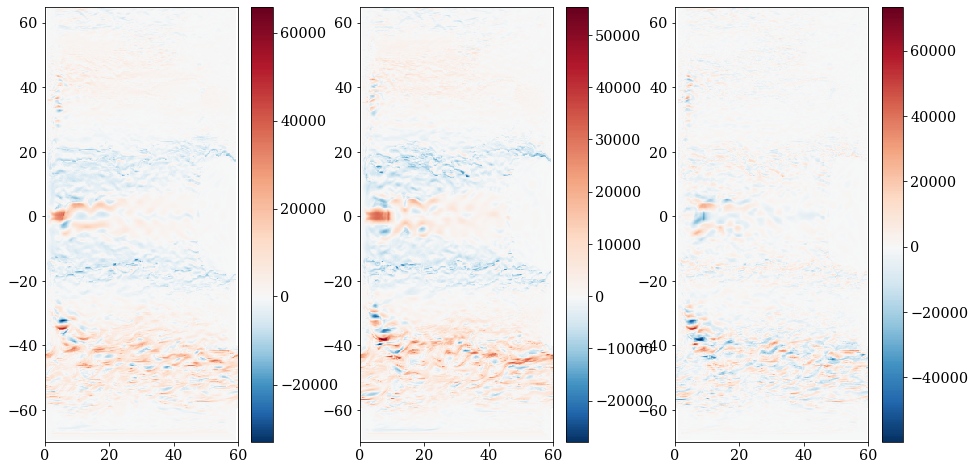

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.pcolormesh(av1.xq,av1.yh.values[:lat_no],u_temp1_5[0],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(av1.xq,av1.yh.values[:lat_no],u_temp5[0],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(av1.xq,av1.yh.values[:lat_no],u_temp1_5[0]-u_temp5[0],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.savefig('Comparison_1_and_5_day_velocities.png', dpi=200,bbox_inches='tight',pad_inches=0)

Text(0, 0.5, '5-day averaged of u')

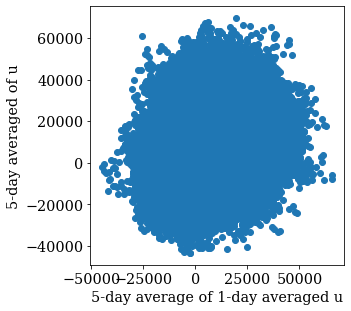

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.scatter(u_temp1_5,u_temp5)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('5-day average of 1-day averaged u')
plt.ylabel('5-day averaged of u')

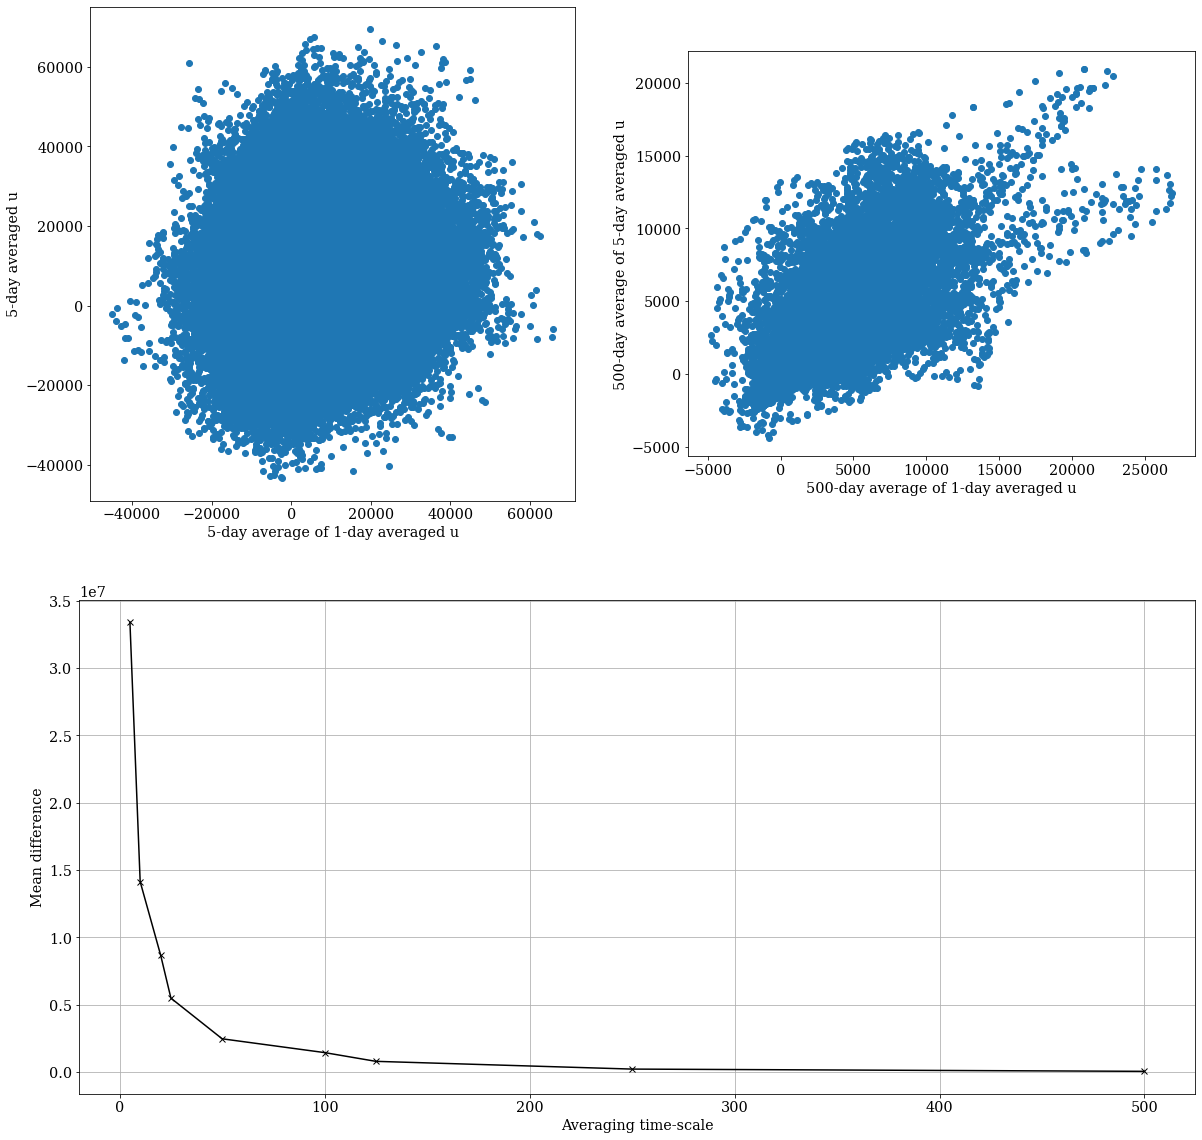

In [21]:
time_avg = [1,2,4,5,10,20,25,50,100]
difference = np.zeros((len(time_avg)))

for i in range(len(time_avg)):
    u_temp1_avg = u_temp1_5.reshape((-1, time_avg[i], 161, 241)).mean(axis=1) # longer-time averages estimated from 1-day averaged values
    u_temp5_avg = u_temp5.reshape((-1, time_avg[i], 161, 241)).mean(axis=1) # longer-time averages estimated from 5-day averaged values
    difference[i] = np.nansum(abs(u_temp1_avg-u_temp5_avg)/abs(u_temp5_avg)) # Mean difference
    

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.scatter(u_temp1_5,u_temp5)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('5-day average of 1-day averaged u')
plt.ylabel('5-day averaged u')

plt.subplot(2,2,2)
plt.scatter(u_temp1_avg,u_temp5_avg)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('500-day average of 1-day averaged u')
plt.ylabel('500-day average of 5-day averaged u')

plt.subplot(2,1,2)
plt.plot(np.array(time_avg)*5,difference,'kx-')
plt.ylabel('Mean difference')
plt.xlabel('Averaging time-scale')
plt.grid()
plt.savefig('Comparison_velocities.png', dpi=200,bbox_inches='tight',pad_inches=0)

In [22]:
difference

array([33415355.72882119, 14141429.26253255,  8680862.64080293,
        5494644.89033197,  2476883.35212658,  1452341.00235464,
         803449.46415186,   228216.91583811,    61345.74110636])

In [24]:
av5

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zl: 15)
Coordinates:
  * xq          (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time        (time) float64 2.8e+04 2.801e+04 ... 2.849e+04 2.85e+04
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yq          (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
Data variables:
    u           (time, zl, yh, xq) float32 ...
    v           (time, zl, yq, xh) float32 ...
    h           (time, zl, yh, xh) float32 nan nan nan nan ... nan nan nan nan
    uh          (time, zl, yh, xq) float32 nan nan nan nan ... nan nan nan nan
    vh          (time, zl, yq, xh) float32 nan nan nan nan ... nan nan nan nan
    RV          (time, zl, yq, xq) float32 ...
    RV2         (time, zl, yq, xq) float32 ...
    NoSt2       (time, zl, yh, xh) float32 ...
    ShSt2       (time, zl, yq, xq) float32 ...
    average_T1  (time) float64 ...
    average_T2  (time) float64 ...
    average_DT  (time) float64 ...
    time_bnds   (time, nv) float64 ...
Attributes:
    filename:          averages_00028002.nc
    title:             NeverWorld2
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

In [23]:
av1

<xarray.Dataset>
Dimensions:     (nv: 2, time: 500, xh: 240, xq: 241, yh: 560, yq: 561, zl: 15)
Coordinates:
  * xq          (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time        (time) float64 2.8e+04 2.8e+04 2.8e+04 ... 2.85e+04 2.85e+04
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yq          (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
Data variables:
    u           (time, zl, yh, xq) float32 ...
    v           (time, zl, yq, xh) float32 ...
    h           (time, zl, yh, xh) float32 nan nan nan nan ... nan nan nan nan
    uh          (time, zl, yh, xq) float32 nan nan nan nan ... nan nan nan nan
    vh          (time, zl, yq, xh) float32 nan nan nan nan ... nan nan nan nan
    RV          (time, zl, yq, xq) float32 ...
    RV2         (time, zl, yq, xq) float32 ...
    NoSt2       (time, zl, yh, xh) float32 ...
    ShSt2       (time, zl, yq, xq) float32 ...
    average_T1  (time) float64 ...
    average_T2  (time) float64 ...
    average_DT  (time) float64 ...
    time_bnds   (time, nv) float64 ...
Attributes:
    filename:          averages_00028000.nc
    title:             NeverWorld2
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A